In [25]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# import

In [26]:
# export
from fastai.basic_train import LearnerCallback

In [27]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [28]:
# export
from fastai.core import *

In [29]:
# export
from IPython.core import debugger as idb

In [30]:
from torch.utils.tensorboard import SummaryWriter

In [49]:
# export
from exp import nb_resnet_unet
from exp import nb_loss_metrics
from exp import nb_optimizer
from exp import nb_tensorboard_callback
from exp import nb_scheduling_train
from exp import nb_databunch
from exp import nb_train_script_logger

In [32]:
# export
import torch

In [33]:
# export
from torch import tensor

In [34]:
# export
from torch import nn

In [35]:
# export
from torch.nn import Sequential, ModuleList

In [36]:
# export
from fastai.basic_train import Learner

In [37]:
# export
from fastai.torch_core import bn_types,bias_types

In [38]:
# export
from functools import partial

In [39]:
# export
import os,shutil

In [40]:
# export
from fastai.callbacks import CSVLogger

In [41]:
# export
from fastai.callbacks.tracker import SaveModelCallback

In [42]:
import shutil

# functions

In [43]:
# export
def get_learn(data, model_name = 'resnet18', allres = True, loss_func_name = 'balance_bce', balance_ratio = 1):
    assert model_name in ['resnet18', 'assert34'], 'invalid model name'
    assert loss_func_name in ['balance_bce', 'dice_loss', 'combo_loss'], 'invalid loss func name'
    # create model
    model = None
    if model_name == 'resnet18':
        model = nb_resnet_unet.get_unet_res18(1, allres)
        if allres:
            model.load_state_dict(torch.load('./models/unet_res18_allres_init.pth'))
        else:
            model.load_state_dict(torch.load('./models/unet_res18_valina_init.pth'))
    elif model_name == 'resnet34':
        model = nb_resnet_unet.get_unet_res34(1, allres)
        if allres:
            model.load_state_dict(torch.load('./models/unet_res34_allres_init.pth'))
        else:
            model.load_state_dict(torch.load('./models/unet_res34_valina_init.pth'))
    
    # create learner
    learn = Learner(data,model)
    
    # split model
    learn.layer_groups = nb_train_script_logger.split_model(learn.model)
    
    # set multi-gpu
    if data.device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1,2,3,4,5])
        
    # set loss func
    if loss_func_name == 'combo_loss':
        learn.loss_func = partial(nb_loss_metrics.combo_loss, balance_ratio=balance_ratio)
    elif loss_func_name == 'dice_loss':
        learn.loss_func = nb_loss_metrics.dice_loss
    elif loss_func_name == 'balance_bce':
        learn.loss_func = partial(nb_loss_metrics.balance_bce, balance_ratio=balance_ratio)
    
    # 添加metrics
    learn.metrics += [nb_loss_metrics.dice_loss]
    learn.metrics += [partial(nb_loss_metrics.balance_bce,balance_ratio=1)]
    learn.metrics += [nb_loss_metrics.mask_iou]
    
    return learn

In [44]:
#export
model_names = ['resnet18', 'assert34']
loss_func_names = ['dice_loss', 'balance_bce', 'combo_loss']
balance_ratios = [1, 0.1, 10]
dataset_dirs = ['data/dataset_20200715', 'data/dataset_20200715_2000', 'data/dataset_20200715_200_et']
dataset_names = ['dataset200', 'dataset2000', 'dataset200_et']

In [45]:
#把结果备份一下
def backup_train_logs(tag, dst_root = 'train_logs'):    
    src_dirs = ['run_log', 'tb_log']
    path = os.path.join(dst_root, tag)
    os.makedirs(path, exist_ok = True)
    for d in src_dirs:        
        dst = os.path.join(dst_root, tag, d)
        #3.8的python才有dirs_exist_ok。现在只能先删掉
        shutil.rmtree(dst, ignore_errors = True)
        shutil.copytree(d, dst)
    ds = tag.split('__')[3]
    assert ds in dataset_names, ds + '???'
    csvpath = dataset_dirs[dataset_names.index(ds)] + '/image'
    shutil.rmtree(os.path.join(path, 'csv_log'), ignore_errors = True)
    #print(os.path.join(csvpath, 'csv_log'), path)
    shutil.copytree(os.path.join(csvpath, 'csv_log'), os.path.join(path, 'csv_log'))

# test

In [46]:
# export
# 设置device
device = torch.device('cuda')

In [47]:
BS = 16

In [69]:
# 200数据集
ds = './data/dataset_20200715'
data_200 = nb_databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [85]:
# 2000数据集
ds = './data/dataset_20200715_2000'
data_2000 = nb_databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [50]:
# 200带elastic_transform数据集
ds = './data/dataset_20200715_200_et'
data_200et = nb_databunch.get_databunch_et(ds, bs=BS, device=device, transforms = None) 

In [54]:
optf_adam = partial(nb_optimizer.Adam, betas=(0.9,0.99))

## 数据集比较

### 200数据集，无transform,resnet18，allres,dice,adam

In [81]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200', 'adam'])

In [70]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


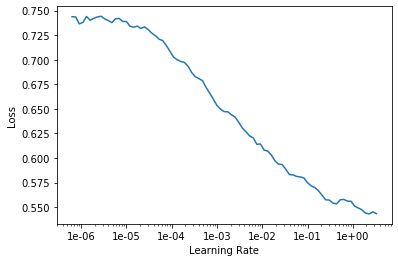

In [64]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [71]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


Better model found at epoch 0 with valid_loss value: 0.755079448223114.
Better model found at epoch 1 with valid_loss value: 0.695042610168457.
Better model found at epoch 2 with valid_loss value: 0.6032920479774475.
Better model found at epoch 3 with valid_loss value: 0.5330035090446472.
Better model found at epoch 4 with valid_loss value: 0.5104333162307739.
Better model found at epoch 5 with valid_loss value: 0.3967370092868805.
Better model found at epoch 6 with valid_loss value: 0.2816401720046997.
Better model found at epoch 8 with valid_loss value: 0.230955570936203.
Better model found at epoch 9 with valid_loss value: 0.19004663825035095.
Better model found at epoch 12 with valid_loss value: 0.16728903353214264.
Better model found at epoch 14 with valid_loss value: 0.1649456024169922.
Better model found at epoch 15 with valid_loss value: 0.1338915377855301.
Better model found at epoch 17 with valid_loss value: 0.13074588775634766.
Better model found at epoch 18 with valid_loss 

In [82]:
backup_train_logs(tag)

In [ ]:
epochs:240,train_loss:0.012935,mask_iou:0.922264

### 2000数据集，无transform,resnet18，allres,dice,adam

In [87]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset2000','adam'])

In [88]:
getlearn = partial(get_learn, data = data_2000, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


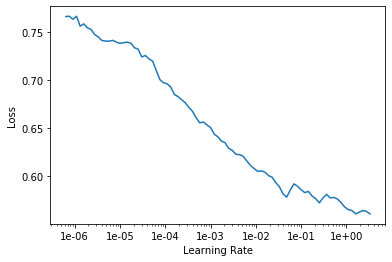

In [83]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [89]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


Better model found at epoch 0 with valid_loss value: 0.27596670389175415.
Better model found at epoch 1 with valid_loss value: 0.11078394204378128.
Better model found at epoch 2 with valid_loss value: 0.09720931947231293.
Better model found at epoch 3 with valid_loss value: 0.07252483069896698.
Better model found at epoch 4 with valid_loss value: 0.06815541535615921.
Better model found at epoch 6 with valid_loss value: 0.05666894093155861.
Better model found at epoch 7 with valid_loss value: 0.05271410942077637.
Better model found at epoch 8 with valid_loss value: 0.048200543969869614.
Better model found at epoch 10 with valid_loss value: 0.043685805052518845.
Better model found at epoch 11 with valid_loss value: 0.03827884420752525.
Better model found at epoch 12 with valid_loss value: 0.036419838666915894.
Better model found at epoch 15 with valid_loss value: 0.031563516706228256.
Better model found at epoch 19 with valid_loss value: 0.030112363398075104.
Better model found at epoch 

Better model found at epoch 221 with valid_loss value: 0.008396374993026257.
Better model found at epoch 223 with valid_loss value: 0.008363435044884682.
Better model found at epoch 226 with valid_loss value: 0.008266935124993324.
on end of epoch#226: start annealing from 0.0001 to 1e-05
Better model found at epoch 227 with valid_loss value: 0.008151202462613583.
Better model found at epoch 228 with valid_loss value: 0.008087804540991783.
Better model found at epoch 234 with valid_loss value: 0.008083577267825603.
Better model found at epoch 236 with valid_loss value: 0.008028528653085232.
Better model found at epoch 238 with valid_loss value: 0.008004915900528431.
Better model found at epoch 241 with valid_loss value: 0.008002088405191898.
Better model found at epoch 245 with valid_loss value: 0.008000807836651802.
Better model found at epoch 250 with valid_loss value: 0.007980945520102978.
Better model found at epoch 253 with valid_loss value: 0.007964667864143848.
on end of epoch#25

In [110]:
backup_train_logs(tag)

In [ ]:
epochs:256,train_loss:0.002,mask_iou:0.984

### 200_et数据集，无transform,resnet18，allres,dice,adam

In [51]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200_et','adam'])

In [52]:
getlearn = partial(get_learn, data = data_200et, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


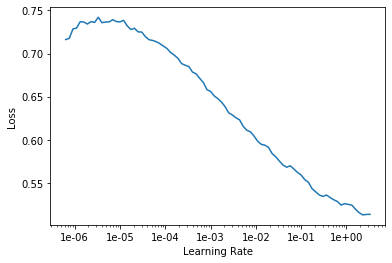

In [55]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [56]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


Better model found at epoch 0 with valid_loss value: 0.6730028986930847.
Better model found at epoch 1 with valid_loss value: 0.4806247651576996.
Better model found at epoch 2 with valid_loss value: 0.3284897804260254.
Better model found at epoch 3 with valid_loss value: 0.2502334713935852.
Better model found at epoch 6 with valid_loss value: 0.24698877334594727.
Better model found at epoch 7 with valid_loss value: 0.19469943642616272.
Better model found at epoch 8 with valid_loss value: 0.17441478371620178.
Better model found at epoch 9 with valid_loss value: 0.1401984989643097.
Better model found at epoch 11 with valid_loss value: 0.11481285095214844.
Better model found at epoch 13 with valid_loss value: 0.0872698649764061.
Better model found at epoch 14 with valid_loss value: 0.08725808560848236.
Better model found at epoch 18 with valid_loss value: 0.07185699045658112.
Better model found at epoch 21 with valid_loss value: 0.06715203821659088.
Better model found at epoch 25 with val

In [57]:
backup_train_logs(tag)

In [ ]:
epochs:113,train_loss:0.023,mask_iou:0.918

# export

In [58]:
!python notebook2script.py --fname 'train_eval.ipynb' --outputDir './exp/'

Converted train_eval.ipynb to exp/nb_train_eval.py
